In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# notebooks/example_notebook.ipynb

import sys
import os
sys.path.append(os.path.abspath('../scripts'))

In [3]:
from load_data import load_data_from_postgres, load_data_using_sqlalchemy
from sql_queries import execute_telecom_queries

In [4]:
# Define your SQL query
query = "SELECT * FROM xdr_data;"  # Replace with your actual table name

# Load data from PostgreSQL
data = load_data_from_postgres(query)

# Display the first few rows of the dataframe
if data is not None:
    print("Successfully loaded the data")
else:
    print("Failed to load data.")


c:\Users\HP\Desktop\Challenges\Telcom\scripts\load_data.py:38: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


Successfully loaded the data


In [5]:
# Handle missing values
data.fillna(data.mean(numeric_only=True), inplace=True)
data['Handset Type'].fillna(data['Handset Type'].mode()[0], inplace=True)

C:\Users\HP\AppData\Local\Temp\ipykernel_30904\1079259648.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Handset Type'].fillna(data['Handset Type'].mode()[0], inplace=True)


In [7]:
# Aggregate metrics per customer
agg_data = data.groupby('MSISDN/Number').agg({
    'TCP DL Retrans. Vol (Bytes)': 'mean',
    'TCP UL Retrans. Vol (Bytes)': 'mean',
    'Avg RTT DL (ms)': 'mean',
    'Avg RTT UL (ms)': 'mean',
    'Avg Bearer TP DL (kbps)': 'mean',
    'Avg Bearer TP UL (kbps)': 'mean',
    'Handset Type': lambda x: x.mode()[0]
}).reset_index()

In [8]:
# Compute average metrics
agg_data['Average TCP Retransmission'] = (agg_data['TCP DL Retrans. Vol (Bytes)'] + agg_data['TCP UL Retrans. Vol (Bytes)']) / 2
agg_data['Average RTT'] = (agg_data['Avg RTT DL (ms)'] + agg_data['Avg RTT UL (ms)']) / 2
agg_data['Average Throughput'] = (agg_data['Avg Bearer TP DL (kbps)'] + agg_data['Avg Bearer TP UL (kbps)']) / 2

In [9]:
# Task 3.2 - Extremes and Frequencies
top_tcp = agg_data.nlargest(10, 'Average TCP Retransmission')
bottom_tcp = agg_data.nsmallest(10, 'Average TCP Retransmission')
most_frequent_tcp = agg_data['Average TCP Retransmission'].mode()


In [10]:
# Task 3.3 - Analysis per Handset Type
throughput_by_handset = agg_data.groupby('Handset Type')['Average Throughput'].mean()
tcp_by_handset = agg_data.groupby('Handset Type')['Average TCP Retransmission'].mean()


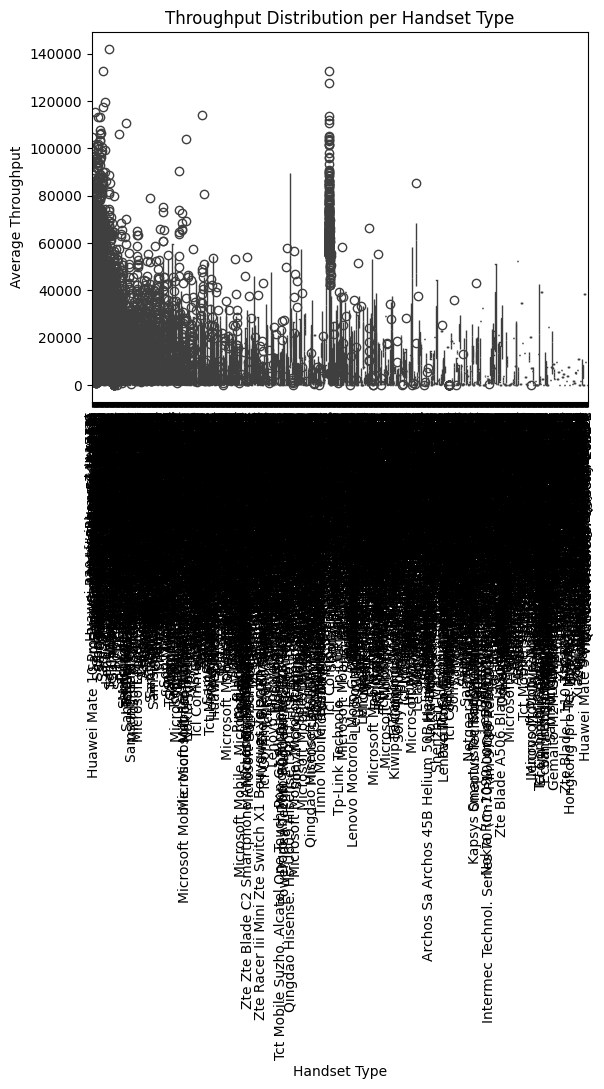

In [11]:
# Visualize distributions
sns.boxplot(x='Handset Type', y='Average Throughput', data=agg_data)
plt.title('Throughput Distribution per Handset Type')
plt.xticks(rotation=90)
plt.show()

In [12]:
# Task 3.4 - k-Means Clustering
scaler = MinMaxScaler()
normalized_metrics = scaler.fit_transform(agg_data[['Average TCP Retransmission', 'Average RTT', 'Average Throughput']])

kmeans = KMeans(n_clusters=3, random_state=42)
agg_data['Cluster'] = kmeans.fit_predict(normalized_metrics)


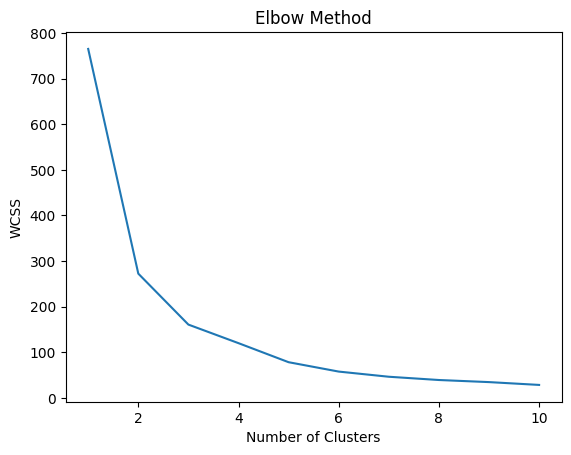

In [13]:
# Elbow method
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(normalized_metrics)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()


In [14]:
# Cluster analysis
cluster_summary = agg_data.groupby('Cluster').agg({
    'Average TCP Retransmission': ['mean', 'std'],
    'Average RTT': ['mean', 'std'],
    'Average Throughput': ['mean', 'std']
}).reset_index()

print(cluster_summary)

  Cluster Average TCP Retransmission               Average RTT              \
                                mean           std        mean         std   
0       0               8.812973e+06  6.857031e+06   71.764409  334.658420   
1       1               9.045308e+06  5.611407e+07   56.348998   84.882401   
2       2               3.809611e+07  1.800258e+08   47.180367   46.336773   

  Average Throughput                
                mean           std  
0        1124.907677   2249.081237  
1       17455.382532   5634.110249  
2       42272.099205  12997.041746  
